# censor-fix example notebook

In [4]:
cd ../../censorfix

/home/klsp955/pypy/censor-fix/censorfix


In [13]:
ls

censorfix.py     __init__.py  __pycache__/
compile_stan.py  notebooks/   test_censor.py


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from censorfix import censorfix

In [14]:
# %load -s create_data test_censor.py
def create_data():
    """
    returns two dataframes a copy of one another
    """
    c = 0.5
    n = 3
    cov = c + np.identity(n) * (1 - c)
    size = 100
    full_data = np.random.multivariate_normal(
        [0 for i in range(n)], cov, size=size)
    df = pd.DataFrame(full_data)
    df2 = df.copy()
    return df, df2


In [17]:
# %load -s single_dim_test test_censor.py
def single_dim_test():
    """
    Test censorfix in one d example
    """
    df, df2 = create_data() 
    censor_high = 1.5
    censor_low =- 0.5
    df.loc[df[0] > censor_high, 0] = censor_high
    df.loc[df[0] < censor_low, 0] = censor_low
    imp = censorfix.censorImputer(
        debug=False, no_columns=2, sample_posterior=True)
    df = df.sort_values(by=0, ascending=True)
    imp.impute_once(df[0], df[[1, 2]], censor_high, censor_low)
    fig, ax = plt.subplots(1, 1)
    df2.plot(kind='scatter', x=0, y=2, ax=ax, color='pink',label='imputed')
    df.plot(kind='scatter', x=0, y=2, ax=ax,label='true')
    plt.title('single imputation of censored values')
    plt.show()
    return df,df2


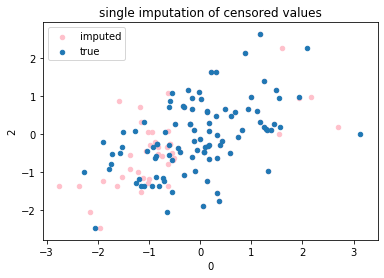

In [19]:
single_dim_test();

In [5]:
# %load -s multi_imp_test test_censor.py
def multi_imp_test(plot=True):
    """
    Tests the creation of multiple imputations
    plots results or returns dataframe and the imputed data
    """
    df, df2 = create_data()
    # censor the first dataframe
    censor_high_1=0.8
    censor_high_2=1
    censor_low_1=-0.6
    censor_low_2=-2
    df.loc[df[0] > censor_high_1, 0] = censor_high_1
    df.loc[df[0] < censor_low_1, 0] = censor_low_1
    df.loc[df[1] > censor_high_2, 1] = censor_high_2
    df.loc[df[1] < censor_low_2, 1] = censor_low_2

    imp = censorfix.censorImputer(
        debug=False, sample_posterior=True,number_imputations=3)
    U = [censor_high_1, censor_high_2, 'NA']  # the upper censor values
    L = [censor_low_1, censor_low_2, 'NA'] # the lower censor values

    data_mi = imp.impute(df, U, L, iter_val=2)

    if plot:
        fig, ax = plt.subplots(1, 1)
        colours=['red','yellow','green']
        for i,data in enumerate(data_mi):
            data.plot(kind='scatter',x=0,y=1,color=colours[i],label='imputation {}'.format(i),ax=ax)
        df2.plot(kind='scatter',x=0,y=1,color='blue',label='original',ax=ax)
        plt.title('Multiple imputations comparison')
        plt.legend()
        plt.show()
    return df2, data_mi


100%|██████████| 1/1 [00:04<00:00,  4.91s/it]


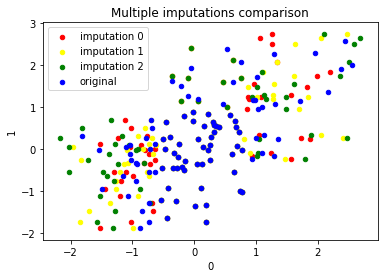

In [21]:
censorfix.multi_imp_test();

In [6]:
# %load -s multi_dim_test test_censor.py
def multi_dim_test():
    """
    Test censorfix for multiple imputation of multiple dimensions
    """
    df, df2 = create_data() 

    # censor the first dataframe
    censor_high_1=0.8
    censor_high_2=0.5
    censor_low_1=-0.3
    censor_low_2=-0.7
    df.loc[df[0] > censor_high_1, 0] = censor_high_1
    df.loc[df[0] < censor_low_1, 0] = censor_low_1
    df.loc[df[1] > censor_high_2, 1] = censor_high_2
    df.loc[df[1] < censor_low_2, 1] = censor_low_2

    imp = censorfix.censorImputer(
        debug=False, sample_posterior=True)
    U = [censor_high_1, censor_high_2, 'NA']  # the upper censor values
    L = [censor_low_1, censor_low_2, 'NA'] # the lower censor values
 
    fig, ax = plt.subplots(1, 1)
    df.plot(kind='scatter', x=0, y=1, ax=ax, color='yellow', label='censored')
    df = imp.impute(df, U, L, iter_val=2)
    df2.plot(
        kind='scatter',
        x=0,
        y=1,
        ax=ax,
        color='pink',
        label='imputed_values')
    df.plot(kind='scatter', x=0, y=1, ax=ax, label='actual')
    plt.legend()
    plt.title('Multivariate Censor Imputation')
    plt.show()
    return df,df2


100%|██████████| 2/2 [00:12<00:00,  6.09s/it]


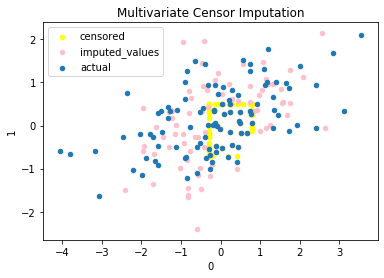

In [2]:
censorfix.multi_dim_test();

In [24]:
def censor_ex():
    plt.rc('font', size=16)
    x = np.random.rand(100)
    y = x**3 + 2 * x**0.1 + 0.5 * np.random.rand(100)
    fig = plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(x, y)
    plt.title('Drug Data True Values')
    plt.xlabel('BSEP')
    plt.ylabel('SPHER')
    plt.ylim(1, 3.5)

    y[y > 2.3] = 2.3
    plt.subplot(1, 2, 2)
    plt.scatter(x, y)
    plt.title('Drug Data Censored')
    plt.xlabel('BSEP')
    plt.ylabel('SPHER')
    plt.ylim(1, 3.5)
    return x,y

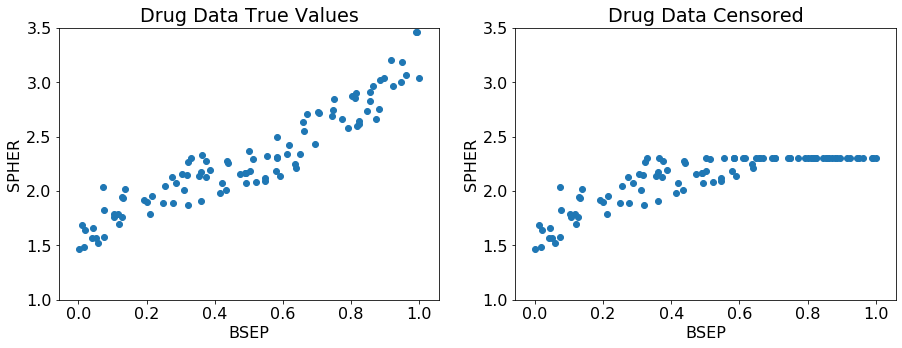

In [29]:
x,y=censor_ex();

In [30]:
# %load -s censor_fix_ex  pressy.py
def censor_fix_ex():
    import censorfix
    plt.rc('font', size=12)
    fig = plt.figure(figsize=(15, 5))
    imp = censorfix.censorImputer(
        debug=False, no_columns=1, sample_posterior=False)
    df = pd.DataFrame([y, x]).T
    df = df.sort_values(by=0, ascending=True)
    imp.impute_once(df[0], df[[1]], 2.3, 'NA')

    plt.subplot(1, 2, 1)
    plt.scatter(df.iloc[:, 1], df.iloc[:, 0])
    plt.title('Drug Data Best Imputation')
    plt.xlabel('BSEP')
    plt.ylabel('SPHER')
    plt.ylim(1, 3.5)

    imp = censorfix.censorImputer(
        debug=False,
        no_columns=1,
        sample_posterior=True)
    df = pd.DataFrame([y, x]).T
    df = df.sort_values(by=0, ascending=True)
    imp.impute_once(df[0], df[[1]], 2.3, 'NA')
    plt.subplot(1, 2, 2)

    plt.scatter(df.iloc[:, 1], df.iloc[:, 0])
    plt.title('Drug Data Imputation from the Bayesian posterior ')
    plt.xlabel('BSEP')
    plt.ylabel('SPHER')
    plt.ylim(1, 3.5)

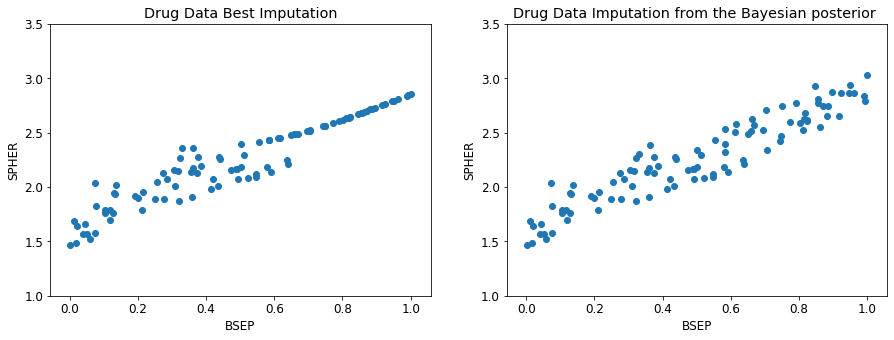

In [31]:
censor_fix_ex()

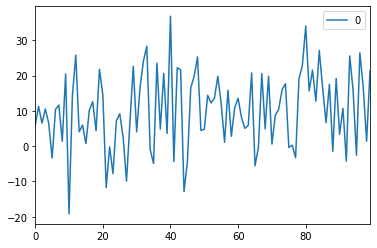

In [23]:
df, df2 = create_data() 
censor_high = 1.5
censor_low =- 0.5
df.loc[df[0] > censor_high, 0] = censor_high
df.loc[df[0] < censor_low, 0] = censor_low
imp = censorfix.censorImputer(
    debug=False, no_columns=2, sample_posterior=False)
df = df.sort_values(by=0, ascending=True)
imp.impute_once(df[0], df[[1, 2]], censor_high, censor_low)
fig, ax = plt.subplots(1, 1)
df2.plot(kind='scatter', x=0, y=2, ax=ax, color='pink',label='imputed')
df.plot(kind='scatter', x=0, y=2, ax=ax,label='true')
plt.title('single imputation of censored values')
plt.show()